# Feature Information

### train.csv

the train set, containing the user ids and whether they have churned.

msno: user id

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

### transactions.csv
transactions of users up until 2/28/2017.

msno: user id

payment_method_id: payment method

payment_plan_days: length of membership plan in days

plan_list_price: in New Taiwan Dollar (NTD)

actual_amount_paid: in New Taiwan Dollar (NTD)

is_auto_renew

transaction_date: format %Y%m%d

membership_expire_date: format %Y%m%d

is_cancel: whether or not the user canceled the membership in this transaction.


### user_logs.csv
daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

msno: user id

date: format %Y%m%d

num_25: # of songs played less than 25% of the song length

num_50: # of songs played between 25% to 50% of the song length

num_75: # of songs played between 50% to 75% of of the song length

num_985: # of songs played between 75% to 98.5% of the song length

num_100: # of songs played over 98.5% of the song length

num_unq: # of unique songs played

total_secs: total seconds played
    
    
### members.csv
user information. Note that not every user in the dataset is available.

msno

city

bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.

gender

registered_via: registration method

registration_init_time: format %Y%m%d

expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn 
behavior.


### Impoting Libraries

In [1]:
import numpy as np  # Numerical computing
import pandas as pd # Data manipulation and analysis
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Advanced data visualization
import sklearn # Machine learning algorithms and tools
import tensorflow as tf # Deep learning framework
import keras # High-level neural networks API
import statsmodels.api as sm # Statistical modeling
import scipy.stats as stats # Scientific computing
import plotly.express as px # Interactive data visualization
import nltk # Natural language processing
import xgboost as xgb # Gradient boosting library
import lightgbm as lgb # Gradient boosting framework
import catboost as cb # Gradient boosting on decision trees
import imblearn # Library for handling imbalanced datasets
# import eli5 # Explanation of machine learning models
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import shap # Interpretability and explainability of models
import os

C:\Users\burzi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datasets (CSV Files)

### Join all the dataframes into one dataframe

In [2]:
import pandas as pd

def read_and_join_csv_files(file_paths, chunk_size=10000):
    """
    Read multiple CSV files efficiently using chunking with Pandas and join them into one DataFrame.
    
    Args:
    - file_paths (dict): Dictionary containing file paths for each CSV file.
    - chunk_size (int, optional): Number of rows to read at a time. Default is 10,000.
    
    Returns:
    - DataFrame: Joined DataFrame containing data from all CSV files.
    """
    # Initialize empty dictionary to store DataFrames for each CSV file
    dfs = {}
    
    # Iterate over each file path and read CSV files in chunks
    for key, file_path in file_paths.items():
        # Initialize empty list to store chunks for the current DataFrame
        chunks = []
        
        # Iterate over chunks for the current DataFrame
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Append the chunk to the list of chunks for the current DataFrame
            chunks.append(chunk)
        
        # Concatenate the chunks for the current DataFrame into a single DataFrame
        df = pd.concat(chunks)
        
        # Store the DataFrame in the dictionary with the corresponding key
        dfs[key] = df
    
    # Join DataFrames
    joined_df = dfs["train"].merge(dfs["members"], on='msno', how='left')
    joined_df = joined_df.merge(dfs["transactions"], on='msno', how='left')
    joined_df = joined_df.merge(dfs["logs"], on='msno', how='left')
    
    return joined_df

# Example usage:
file_paths = {
    "members": "Data/members_v3.csv",
    "train": "Data/train_v2.csv",
    "transactions": "Data/transactions_v2.csv",
    "logs": "Data/user_logs_v2.csv"
}




In [3]:
joined_data_frame = read_and_join_csv_files(file_paths)

In [4]:
joined_data_frame.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,...,NaN,NaN,20170305.0,7.0,0.0,3.0,5.0,71.0,68.0,17599.893
1,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,...,NaN,NaN,20170301.0,138.0,19.0,7.0,1.0,21.0,158.0,8830.433
2,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,...,NaN,NaN,20170319.0,0.0,0.0,0.0,0.0,34.0,17.0,7883.313
3,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,...,NaN,NaN,20170316.0,15.0,0.0,0.0,1.0,38.0,17.0,9029.227
4,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,...,NaN,NaN,20170310.0,0.0,0.0,0.0,0.0,8.0,8.0,1870.110


In [5]:
joined_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16887877 entries, 0 to 16887876
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   is_churn                int64  
 2   city                    float64
 3   bd                      float64
 4   gender                  object 
 5   registered_via          float64
 6   registration_init_time  float64
 7   payment_method_id       float64
 8   payment_plan_days       float64
 9   plan_list_price         float64
 10  actual_amount_paid      float64
 11  is_auto_renew           float64
 12  transaction_date        float64
 13  membership_expire_date  float64
 14  is_cancel               float64
 15  date                    float64
 16  num_25                  float64
 17  num_50                  float64
 18  num_75                  float64
 19  num_985                 float64
 20  num_100                 float64
 21  num_unq                 float

In [6]:
def preprocessing(data):
    '''
    This function takes a pandas dataframe as input, performs preprocessing (like dropping rows with NaN values, etc.),
    and then returns a pandas dataframe.
    
    Args:
        data (pandas.DataFrame): The input DataFrame.
    
    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    '''
    print("Preprocessing...")
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Drop rows with NaN values in any column
    data = data.dropna(how='any')
    print("Dropped rows with NaN values.")

    # Replace 'male' with 1 and 'female' with 2 in 'gender'
    gender_mapping = {'male': 1, 'female': 2}
    data['gender'] = data['gender'].map(gender_mapping)

    # Convert float date to datetime for date columns
    date_columns = ['registration_init_time', 'transaction_date', 'membership_expire_date', 'date']
    for col in date_columns:
        data[col] = pd.to_datetime(data[col], format='%Y%m%d', errors='ignore')
    print("Converted float date columns to datetime.")
    
    # Drop the 'msno' column
    #data = data.drop(columns=['msno'])

    # Reorder columns to move 'is_churn' towards the end
    if 'is_churn' in data.columns:
        churn_column = data.pop('is_churn')
        data['is_churn'] = churn_column

    print("Complete!")
    return data


In [7]:
# Preprocess the undersampled DataFrame 'undersampled_df' using the 'preprocessing' function,
# and store the preprocessed DataFrame in 'preprocessed_df'.
preprocessed_df = preprocessing(joined_data_frame)

Preprocessing...
Dropped rows with NaN values.
Converted float date columns to datetime.
Complete!


In [8]:
preprocessed_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn
11,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13.0,20.0,1,3.0,2013-12-23,36.0,30.0,180.0,180.0,...,0.0,2017-03-20,0.0,1.0,1.0,0.0,0.0,2.0,217.548,1
12,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13.0,20.0,1,3.0,2013-12-23,36.0,30.0,180.0,180.0,...,0.0,2017-03-09,0.0,3.0,1.0,0.0,7.0,9.0,2111.274,1
13,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13.0,20.0,1,3.0,2013-12-23,36.0,30.0,180.0,180.0,...,0.0,2017-03-11,0.0,0.0,0.0,0.0,7.0,7.0,1681.037,1
14,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13.0,20.0,1,3.0,2013-12-23,36.0,30.0,180.0,180.0,...,0.0,2017-03-01,0.0,0.0,0.0,0.0,1.0,1.0,234.161,1
15,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13.0,20.0,1,3.0,2013-12-23,36.0,30.0,180.0,180.0,...,0.0,2017-03-04,0.0,0.0,0.0,0.0,4.0,4.0,992.242,1


# Exploratory Data Analysis

In [9]:
def count_plot(data, columns):
    """
    Plot count plots for specified columns using matplotlib in separate windows.
    
    Args:
    - data (pandas.DataFrame): The DataFrame containing the data.
    - columns (list): List of columns to plot.
    """
    print("Plotting count plots...")
    
    # Plot count plots for each column
    for col in columns:
        # Create a new figure for each plot with larger horizontal size
        plt.figure(figsize=(10, 5))
        
        # Create count plot
        sns.countplot(x=col, data=data, palette='Set2')
        plt.title(f'Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    # Show plots
    plt.show()
    print("Plots completed!")

Plotting count plots...


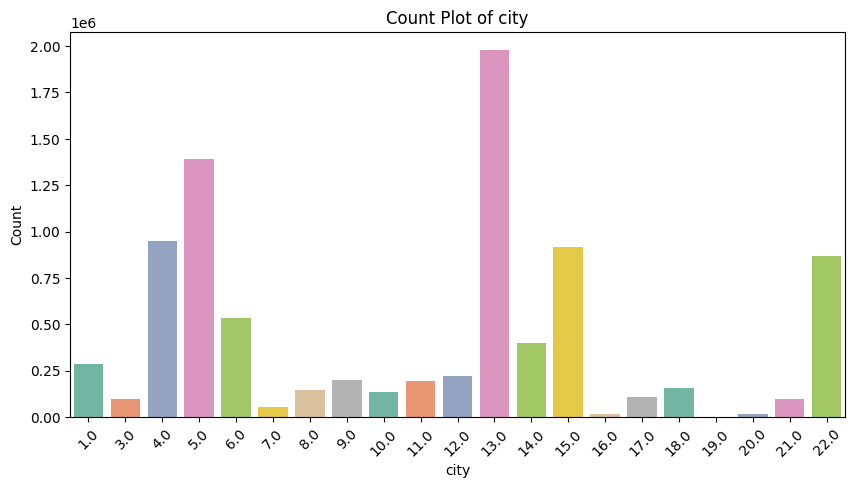

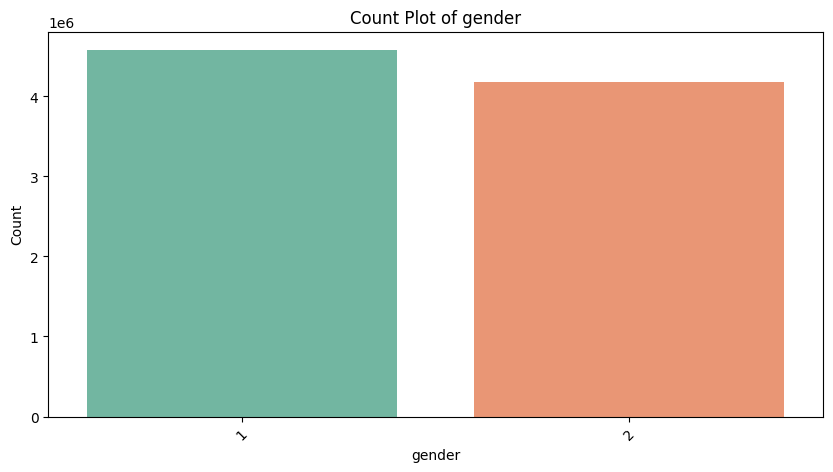

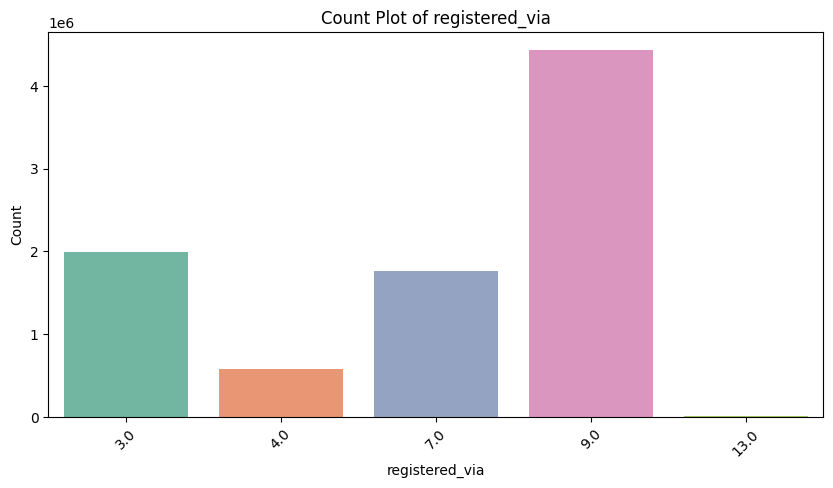

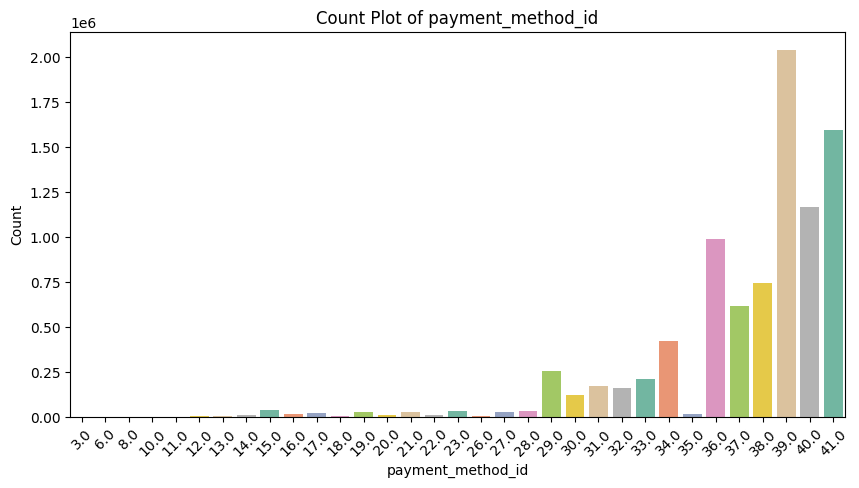

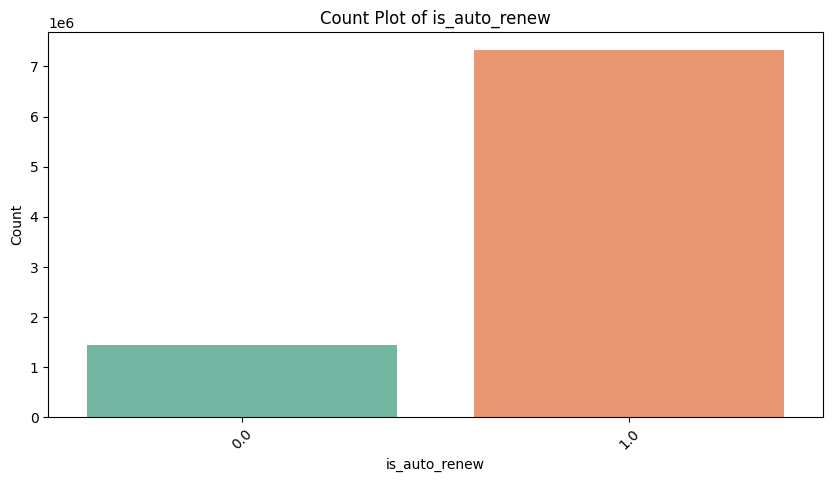

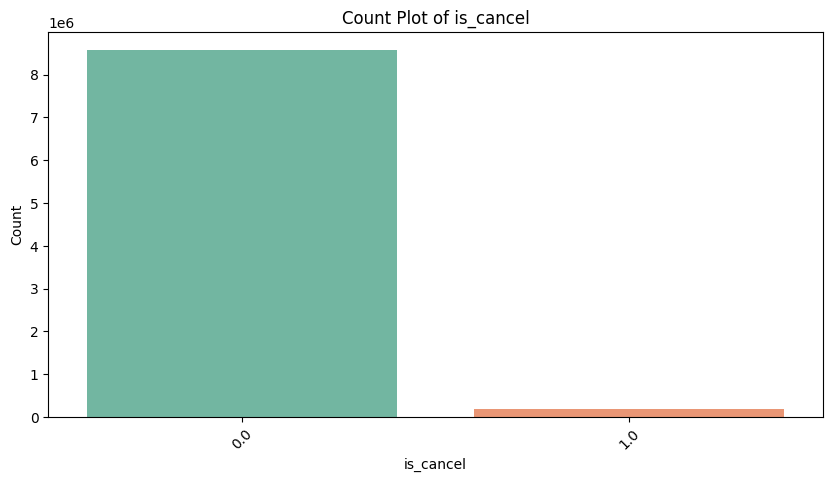

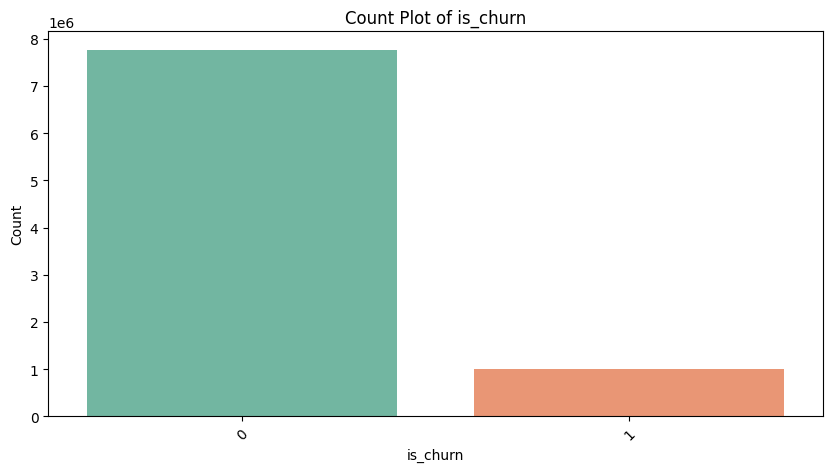

Plots completed!


In [10]:
# Example usage:
# Assuming 'df' is your DataFrame and 'columns' is a list of columns you want to plot
columns_to_plot = ['city', 'gender', 'registered_via', 'payment_method_id', 'is_auto_renew', 'is_cancel', 'is_churn']
count_plot(preprocessed_df, columns_to_plot)

In [11]:
def plot_is_churn(data):
    """
    Plot the distribution of the 'is_churn' column and check the ratio.

    Args:
    - data (pandas.DataFrame): The DataFrame containing the data.
    """
    # Count plot for 'is_churn'
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='is_churn', data=data, palette='Set2')
    plt.title('Distribution of is_churn')
    plt.xlabel('is_churn')
    plt.ylabel('Count')

    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.show()

    # Calculate churn ratio
    churn_ratio = data['is_churn'].value_counts(normalize=True) * 100
    print("Churn ratio:")
    print(churn_ratio)

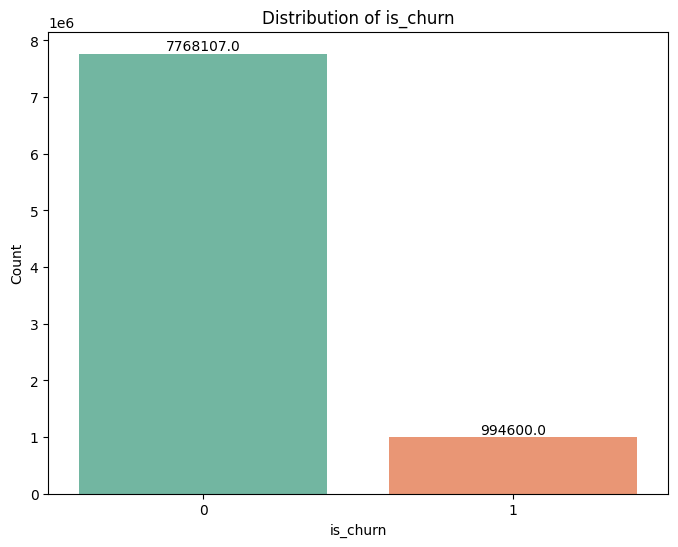

Churn ratio:
is_churn
0    88.649626
1    11.350374
Name: proportion, dtype: float64


In [12]:
# Example usage:
plot_is_churn(preprocessed_df)

The proportion of churned customers to those who haven't churned is imbalanced. To address this, we have the option to either undersample or oversample the data. Given that we have a sufficient number of data points for model training, undersampling the data seems like a viable approach.

# Undersampling the data

In [13]:
def adjust_data_quantity(data: pd.DataFrame, churn_percent: float, data_size_percent: float = 100.0) -> pd.DataFrame:
    '''
    Adjust the quantity of not churned data points while keeping churned data points unchanged.

    Args:
        data (pandas.DataFrame): The input DataFrame.
        churn_percent (float): The percentage of churned data points in the output DataFrame.
        data_size_percent (float, optional): The percentage of data to be used for adjustment. Default is 100.0 (use all data).

    Returns:
        pandas.DataFrame: The adjusted DataFrame.
    '''
    print("Adjusting data quantity...")
    
    # Convert data_size_percent from percentage to fraction
    data_size = data_size_percent / 100.0
    
    # Apply data size adjustment
    data = data.sample(frac=data_size, random_state=0)
    
    # Calculate the number of churned and not churned data points
    churned_count = data['is_churn'].sum()
    not_churned_count = len(data) - churned_count
    
    # Calculate the desired number of not churned data points based on the percentage
    desired_not_churned_count = int(churned_count / (churn_percent / 100))
    
    # If the desired count is less than the current count, sample a subset of not churned data points
    if desired_not_churned_count < not_churned_count:
        # Sample a subset of not churned data points
        not_churned_data = data[data['is_churn'] == 0].sample(n=desired_not_churned_count, replace=False)
        churned_data = data[data['is_churn'] == 1]  # Keep churned data points unchanged
    else:
        # Repeat not churned data points to match the desired count
        repeat_factor = desired_not_churned_count // not_churned_count
        remainder = desired_not_churned_count % not_churned_count
        not_churned_data = pd.concat([data[data['is_churn'] == 0]] * repeat_factor)
        if remainder > 0:
            not_churned_data = pd.concat([not_churned_data, data[data['is_churn'] == 0].sample(n=remainder, replace=False)])
        churned_data = data[data['is_churn'] == 1]  # Keep churned data points unchanged
    
    # Concatenate churned and adjusted not churned data points
    adjusted_data = pd.concat([churned_data, not_churned_data])
    
    print("Data quantity adjustment complete!")
    
    # Calculate and print the ratio of churned to not churned data points
    ratio = churned_count / desired_not_churned_count
    print(f"Ratio of churned to not churned data points: {ratio:.2f}")
    
    # Print value counts after adjustment
    print("Value counts after adjustment:\n", adjusted_data['is_churn'].value_counts())
    
    # Plot count of each class
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    adjusted_data['is_churn'].value_counts().plot(kind='bar', color=['blue', 'orange'])
    plt.title('Count of Each Class')
    plt.xlabel('is_churn')
    plt.ylabel('Count')
    for i, value in enumerate(adjusted_data['is_churn'].value_counts()):
        plt.text(i, value, str(value), ha='center', va='bottom')
    
    # Plot ratio of class 1 to class 0
    plt.subplot(1, 2, 2)
    adjusted_data['is_churn'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
    plt.title('Ratio of Class 1 to Class 0')
    plt.xlabel('is_churn')
    plt.ylabel('Ratio')
    for i, value in enumerate(adjusted_data['is_churn'].value_counts(normalize=True)):
        plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    
    return adjusted_data

Adjusting data quantity...
Data quantity adjustment complete!
Ratio of churned to not churned data points: 0.70
Value counts after adjustment:
 is_churn
0    142085
1     99460
Name: count, dtype: int64


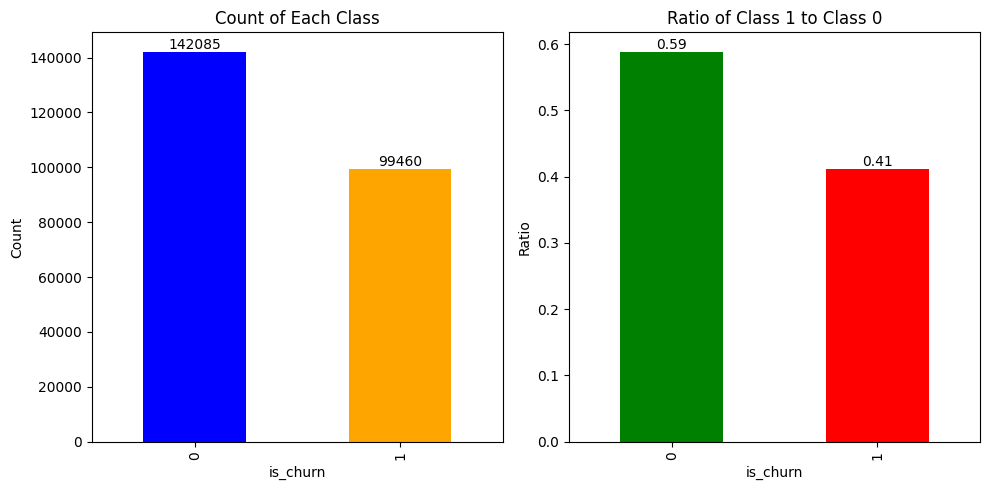

In [14]:
undersampled_df = adjust_data_quantity(preprocessed_df, churn_percent = 70, data_size_percent = 10)

# Feature Engineering

In [15]:
import pandas as pd

def feature_engineering(data):
    '''
    Perform feature engineering on the provided DataFrame.

    Args:
        data (pandas.DataFrame): The input DataFrame containing the original features.

    Returns:
        pandas.DataFrame: The DataFrame with additional engineered features.
    '''

    # Extract year, month, and day from registration_init_time
    data['registration_year'] = data['registration_init_time'].dt.year
    data['registration_month'] = data['registration_init_time'].dt.month
    data['registration_day'] = data['registration_init_time'].dt.day

    # Calculate subscription duration
    data['subscription_duration'] = (data['membership_expire_date'] - data['registration_init_time']).dt.days

    # Extract month and day of the week from date
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek

    # Calculate listening session frequency
    session_count = data.groupby('msno')['date'].count().reset_index()
    session_count.columns = ['msno', 'session_count']
    data = pd.merge(data, session_count, on='msno', how='left')

    # Calculate average listening time per session
    data['avg_listen_time_per_session'] = data['total_secs'] / data['session_count']

    # Calculate ratio of skipped songs
    data['skipped_ratio'] = (data['num_25'] + data['num_50']) / data['num_unq']

    return data

In [16]:
# Apply the 'featurization' function to preprocess the DataFrame 'preprocessed_df' 
# by creating additional features based on existing data, and store the result in 'featurized'.
featurized_df = feature_engineering(undersampled_df)

In [17]:
featurized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241545 entries, 0 to 241544
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   msno                         241545 non-null  object        
 1   city                         241545 non-null  float64       
 2   bd                           241545 non-null  float64       
 3   gender                       241545 non-null  int64         
 4   registered_via               241545 non-null  float64       
 5   registration_init_time       241545 non-null  datetime64[ns]
 6   payment_method_id            241545 non-null  float64       
 7   payment_plan_days            241545 non-null  float64       
 8   plan_list_price              241545 non-null  float64       
 9   actual_amount_paid           241545 non-null  float64       
 10  is_auto_renew                241545 non-null  float64       
 11  transaction_date          

In [18]:
import pandas as pd

def preprocessing_v2(data):
    '''
    Perform preprocessing on the provided DataFrame by dropping specified columns and rearranging the columns.

    Args:
        data (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    '''

    # Drop specified columns
    columns_to_drop = ["msno", "registration_init_time", "transaction_date", "membership_expire_date", "date"]
    data = data.drop(columns=columns_to_drop)

    # Rearrange columns to place "is_churn" at the end
    churn_column = data.pop("is_churn")
    data["is_churn"] = churn_column

    return data

In [19]:
preprocessed_v2_df = preprocessing_v2(featurized_df)

In [20]:
preprocessed_v2_df.head()

,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,...,registration_year,registration_month,registration_day,subscription_duration,month,day_of_week,session_count,avg_listen_time_per_session,skipped_ratio,is_churn
0,22.0,34.0,2,9.0,39.0,30.0,149.0,149.0,1.0,0.0,...,2009,5,31,2894,3,0,10,1263.639400,0.121951,1
1,15.0,38.0,1,9.0,36.0,30.0,180.0,180.0,1.0,1.0,...,2012,10,18,1618,3,2,3,5224.751667,0.250000,1
2,6.0,24.0,2,3.0,36.0,30.0,180.0,180.0,0.0,0.0,...,2017,2,9,64,3,3,4,2757.941000,0.142857,1
3,4.0,22.0,1,3.0,22.0,395.0,1599.0,1599.0,0.0,0.0,...,2013,10,1,1651,3,3,5,3167.055200,0.063830,1
4,9.0,42.0,2,9.0,32.0,410.0,1788.0,1788.0,0.0,0.0,...,2012,7,8,2133,3,1,1,95.713000,1.000000,1


# Outliers and Extra Large Values

In [21]:
def drop_outliers(df, threshold=1.5):
    """
    Drop rows containing outliers in each column of a DataFrame using the IQR method.

    Parameters:
    - df: DataFrame
        The DataFrame to drop outliers from.
    - threshold: float, optional (default=1.5)
        The threshold multiplier for determining outliers. A higher threshold will result in fewer outliers being detected.

    Returns:
    - df_cleaned: DataFrame
        A new DataFrame with rows containing outliers removed.
    """
    df_cleaned = df.copy()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Example usage:
# Assuming df is your DataFrame
# df_cleaned = drop_outliers(df)


In [22]:
outliers_df = drop_outliers(preprocessed_v2_df)

In [23]:
def drop_rows_with_large_values(X, large_threshold=1e6):
    """
    Drop rows containing very large values from the feature matrix X.

    Parameters:
    - X: numpy.ndarray
        The feature matrix.
    - large_threshold: float, optional (default=1e6)
        The threshold for defining very large values.

    Returns:
    - X_cleaned: numpy.ndarray
        The feature matrix with rows containing very large values removed.
    """
    # Check for very large values
    large_rows = np.any(np.abs(X) > large_threshold, axis=1)
    if np.any(large_rows):
        print("Rows with very large values found in X. Dropping...")
        X_cleaned = X[~large_rows]  # Drop rows with large values
    else:
        X_cleaned = X.copy()  # If no large values found, return a copy of X
    return X_cleaned

# Example usage:
# Assuming X is your feature matrix
# X_cleaned = drop_rows_with_large_values(featurized)


In [24]:
large_val_df = drop_rows_with_large_values(outliers_df)

# Separating Dataset into independent and depandent feature dataframes

In [25]:
# Assuming 'df' is your DataFrame and 'target_column' is the name of your target variable column
X = large_val_df.drop(columns=['is_churn'])  # Independent variables (features)
y = large_val_df['is_churn']  # Dependent variable (target)

# Feature Selection

In [37]:
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def select_best_features(X, y, k=10, score_func=f_classif):
    '''
    Selects the best features for a classification problem using SelectKBest.

    Args:
        X (pandas.DataFrame): The DataFrame containing the independent variables.
        y (pandas.Series): The Series containing the dependent variable.
        k (int): The number of top features to select. Default is 10.
        score_func (callable): The scoring function to use for feature selection. Default is f_classif.

    Returns:
        list: A list of selected feature names.
    '''
    # Initialize SelectKBest with the specified scoring function and k
    kb = SelectKBest(score_func=score_func, k=k)
    
    # Fit SelectKBest to the data
    kb.fit(X, y)
    
    # Get the scores and feature indices
    scores = kb.scores_
    indices = np.arange(len(scores))
    
    # Remove features with NaN scores
    non_nan_indices = indices[~np.isnan(scores)]
    non_nan_scores = scores[~np.isnan(scores)]

    # Get the indices of the selected features
    selected_indices = non_nan_indices[np.argsort(non_nan_scores)[::-1][:k]]

    # Get the names and scores of the selected features
    selected_features = [X.columns[i] for i in selected_indices]
    selected_scores = scores[selected_indices]
    
    # Print the statistical report of the selected features
    report = pd.DataFrame({'Feature': selected_features, 'Score': selected_scores})
    print(report.sort_values(by='Score', ascending=False))
    
    # Plot the feature importance
    plt.figure(figsize=(8, 6))
    plt.barh(report['Feature'], report['Score'], color='b')
    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.show()
    
    return selected_features


C:\Users\burzi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 5  9 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\burzi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


                       Feature         Score
0                session_count  80564.627731
1  avg_listen_time_per_session   9391.536214
2                is_auto_renew   5467.664357
3           actual_amount_paid    601.044814
4              plan_list_price    589.056767
5               registered_via    518.080254
6            registration_year    254.945352
7        subscription_duration    242.463400
8                      num_100    215.182829
9                   total_secs    214.214691


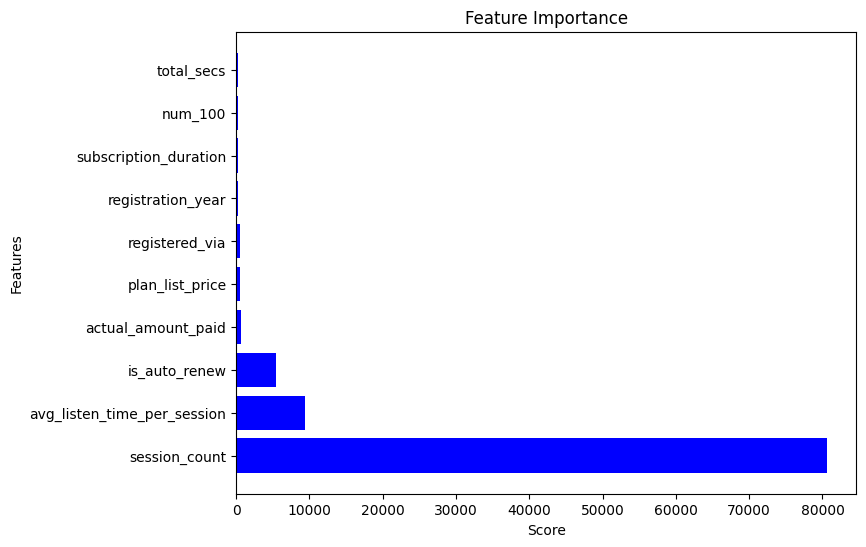

Selected features: ['session_count', 'avg_listen_time_per_session', 'is_auto_renew', 'actual_amount_paid', 'plan_list_price', 'registered_via', 'registration_year', 'subscription_duration', 'num_100', 'total_secs']


In [38]:
# Example usage:
selected_features = select_best_features(X,y,k=10,score_func=f_classif)
print("Selected features:", selected_features)

In [31]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.feature_selection import SelectKBest, mutual_info_classif

# def select_best_features(X, y, k=10):
#     # Initialize SelectKBest with mutual information score function
#     kb = SelectKBest(score_func=mutual_info_classif, k=k)
    
#     # Fit SelectKBest on the data
#     kb.fit(X, y)
    
#     # Get indices of selected features sorted by score
#     indices = np.argsort(kb.scores_)[::-1]
    
#     # Get names of selected features
#     selected_features = X.columns[indices]
    
#     # Get scores of selected features
#     scores = kb.scores_[indices]
    
#     # Print feature scores in descending order
#     print("Feature\t\t\tScore")
#     for feature, score in zip(selected_features, scores):
#         print(f"{feature}\t\t{score}")
    
#     # Plot vertical bar plot of feature scores
#     plt.figure(figsize=(10, 6))
#     plt.bar(selected_features, scores, color='blue')
#     plt.xlabel('Features')
#     plt.ylabel('Mutual Information Score')
#     plt.title('Top {} Features Selected by Mutual Information'.format(k))
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()
    
#     return selected_features.tolist()

Feature			Score
session_count		0.25052739063532803
avg_listen_time_per_session		0.07766139172432829
subscription_duration		0.042533156721074716
is_auto_renew		0.0359511253193332
payment_method_id		0.029079932050008805
actual_amount_paid		0.01882703416610787
plan_list_price		0.015538349582137734
month		0.013433962227690888
payment_plan_days		0.011563782560058744
total_secs		0.011172803809518461
registered_via		0.009713973748564975
gender		0.008456651439944007
registration_year		0.004708328468707279
num_985		0.004163870304185968
day_of_week		0.0038947473706023583
bd		0.0038094086342554956
city		0.0033269171863412605
num_100		0.0028341633462696247
num_50		0.0027670498706029445
registration_day		0.0022579565726981166
num_75		0.002091014871687502
num_unq		0.0018732872689244395
num_25		0.001382613432083346
skipped_ratio		0.00107687990726002
is_cancel		0.0008646061982513498
registration_month		0.0


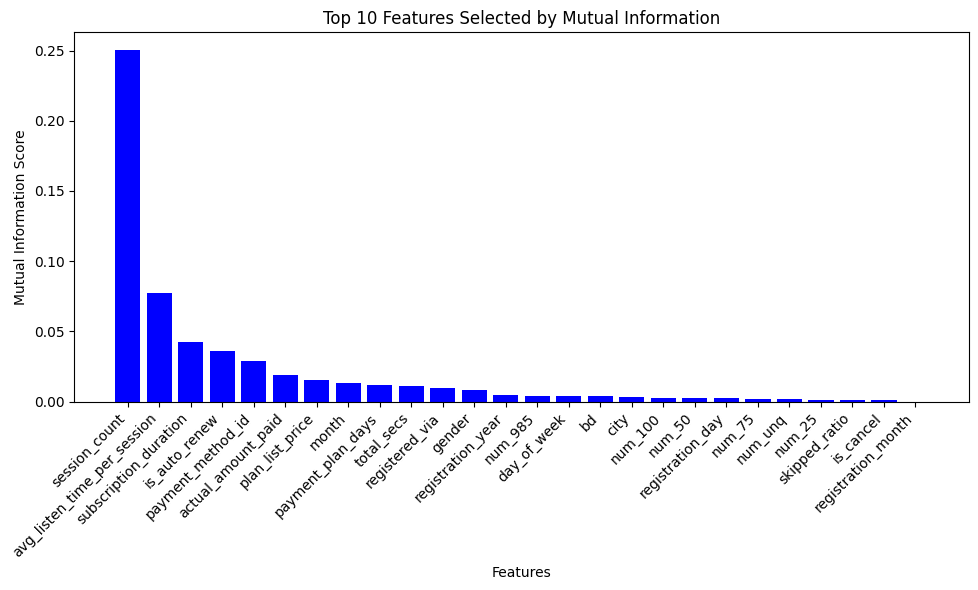

Selected features: ['session_count', 'avg_listen_time_per_session', 'subscription_duration', 'is_auto_renew', 'payment_method_id', 'actual_amount_paid', 'plan_list_price', 'month', 'payment_plan_days', 'total_secs', 'registered_via', 'gender', 'registration_year', 'num_985', 'day_of_week', 'bd', 'city', 'num_100', 'num_50', 'registration_day', 'num_75', 'num_unq', 'num_25', 'skipped_ratio', 'is_cancel', 'registration_month']


In [32]:
# # Example usage:
# # Assuming X is your feature matrix and y is your target variable
# selected_features = select_best_features(X, y, k=10)
# print("Selected features:", selected_features)

In [39]:
X_selected_df = X[selected_features[:10]]

In [40]:
X_selected_df.head()

,session_count,avg_listen_time_per_session,is_auto_renew,actual_amount_paid,plan_list_price,registered_via,registration_year,subscription_duration,num_100,total_secs
2,4,2757.941000,0.0,180.0,180.0,3.0,2017,64,40.0,11031.764
12,11,261.899727,1.0,149.0,149.0,9.0,2004,4581,8.0,2880.897
16,6,268.730167,1.0,149.0,149.0,9.0,2004,4838,6.0,1612.381
21,6,1946.443167,1.0,149.0,149.0,3.0,2012,1924,49.0,11678.659
24,5,3306.995400,1.0,149.0,149.0,4.0,2016,438,73.0,16534.977


In [41]:
def correlation_plot(X, y):
    # Concatenate X and y to create a DataFrame
    data = pd.concat([X, y], axis=1)
    
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap between X and y')
    plt.show()

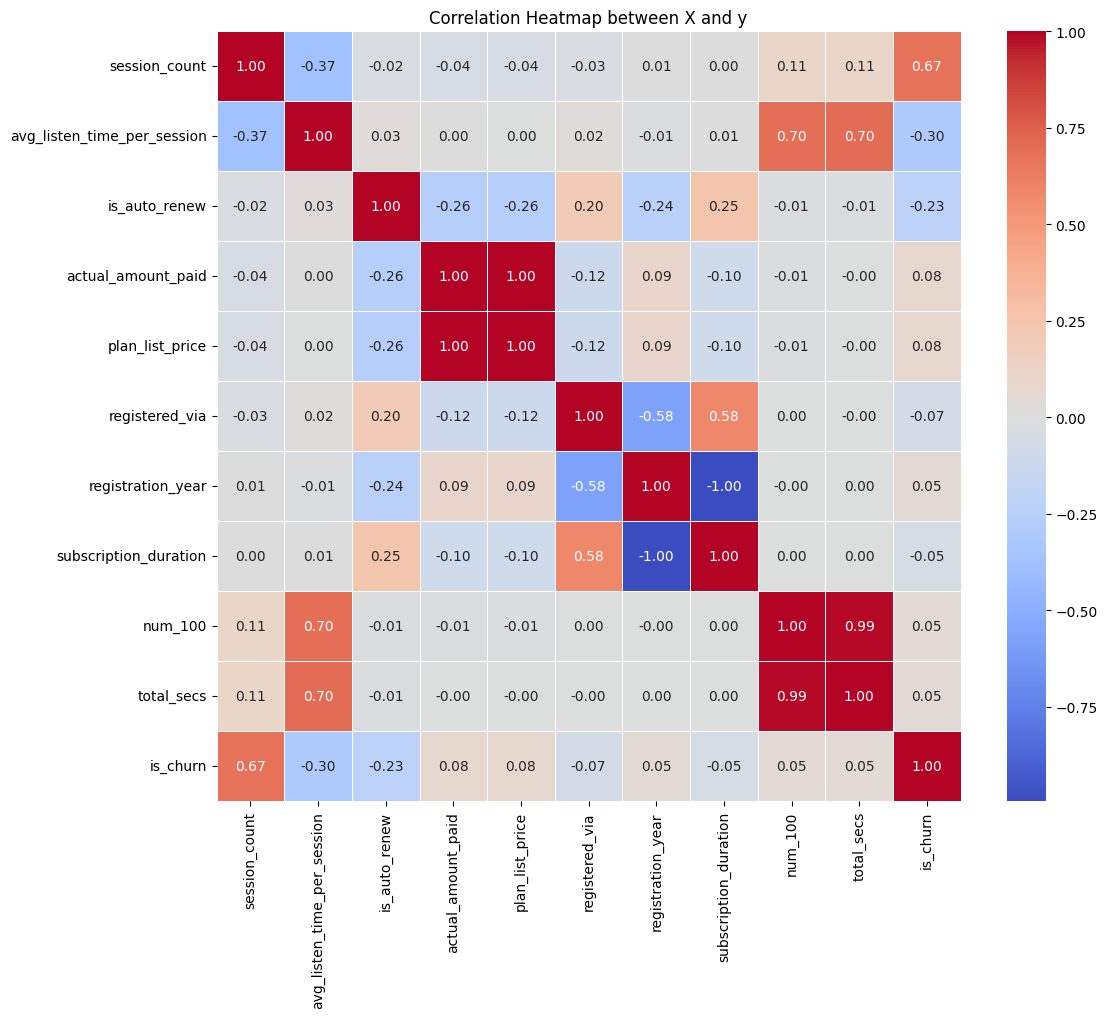

In [42]:
# Example usage:
correlation_plot(X_selected_df, y)

# Train Test Val Split

In [43]:
from sklearn.model_selection import train_test_split

def split_dataset(X, y, test_size=0.2, val_size=0.2, random_state=None):
    """
    Split the dataset into training, validation, and test sets.

    Args:
        X (DataFrame or array-like): The feature matrix.
        y (Series or array-like): The target variable.
        test_size (float or int): The proportion of the dataset to include in the test split.
        val_size (float or int): The proportion of the dataset to include in the validation split.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        Tuple: A tuple containing the following splits: X_train, X_val, X_test, y_train, y_val, y_test.
    """
    print("Splitting dataset into training, validation, and test sets...")
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Dataset split into training set ({len(X_train)} samples) and test set ({len(X_test)} samples)")
    
    # Split the remaining training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size),
                                                      random_state=random_state)
    print(f"Training set further split into training set ({len(X_train)} samples) and validation set ({len(X_val)} samples)")
    
    print("Splitting complete!")
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [44]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, test_size=0.2, val_size=0.2, random_state=42)

Splitting dataset into training, validation, and test sets...
Dataset split into training set (77617 samples) and test set (19405 samples)
Training set further split into training set (58212 samples) and validation set (19405 samples)
Splitting complete!


In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Assuming X_train and X_test are your feature matrices

# Normalize features using MinMaxScaler or StandardScaler
scaler = MinMaxScaler()  # or StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [46]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Train KNN model
# knn_classifier = KNeighborsClassifier()
# knn_classifier.fit(X_train_normalized, y_train)

# # Predict on the test set
# y_pred_knn = knn_classifier.predict(X_test_normalized)

# # Compute performance metrics
# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# precision_knn = precision_score(y_test, y_pred_knn)
# recall_knn = recall_score(y_test, y_pred_knn)
# f1_knn = f1_score(y_test, y_pred_knn)
# confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# # Print performance metrics for KNN classifier
# print("Performance metrics for KNN classifier:")
# print(f"Accuracy: {accuracy_knn}")
# print(f"Precision: {precision_knn}")
# print(f"Recall: {recall_knn}")
# print(f"F1 Score: {f1_knn}")
# print("Confusion Matrix:")
# print(confusion_matrix_knn)


Performance metrics for KNN classifier:
Accuracy: 0.8690543674310744
Precision: 0.821948850760764
Recall: 0.5604856512141281
F1 Score: 0.6664916655729098
Confusion Matrix:
[[14325   550]
 [ 1991  2539]]


In [47]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Train SVC model
# svc_classifier = SVC(kernel='linear')  # or any other kernel
# svc_classifier.fit(X_train_normalized, y_train)

# # Predict on the test set
# y_pred_svc = svc_classifier.predict(X_test_normalized)

# # Compute performance metrics
# accuracy_svc = accuracy_score(y_test, y_pred_svc)
# precision_svc = precision_score(y_test, y_pred_svc)
# recall_svc = recall_score(y_test, y_pred_svc)
# f1_svc = f1_score(y_test, y_pred_svc)
# confusion_matrix_svc = confusion_matrix(y_test, y_pred_svc)

# # Print performance metrics for SVC classifier
# print("Performance metrics for SVC classifier:")
# print(f"Accuracy: {accuracy_svc}")
# print(f"Precision: {precision_svc}")
# print(f"Recall: {recall_svc}")
# print(f"F1 Score: {f1_svc}")
# print("Confusion Matrix:")
# print(confusion_matrix_svc)

Performance metrics for SVC classifier:
Accuracy: 0.9032208193764494
Precision: 0.8722627737226277
Recall: 0.6858719646799117
F1 Score: 0.7679189322787938
Confusion Matrix:
[[14420   455]
 [ 1423  3107]]


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train Random Forest model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test_normalized)

# Compute performance metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print performance metrics for Random Forest classifier
print("Performance metrics for Random Forest classifier:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(confusion_matrix_rf)

from sklearn.metrics import log_loss

# Predict probabilities for each class using the individual decision trees in the Random Forest
y_pred_proba_rf = np.mean([tree.predict_proba(X_test_normalized) for tree in rf_classifier.estimators_], axis=0)

# Calculate log loss
logloss_rf = log_loss(y_test, y_pred_proba_rf)
print(f'Log Loss: {logloss_rf:.4f}')


Performance metrics for Random Forest classifier:
Accuracy: 0.9249677918062355
Precision: 0.9015151515151515
Recall: 0.7618101545253864
F1 Score: 0.8257956448911222
Confusion Matrix:
[[14498   377]
 [ 1079  3451]]
Log Loss: 0.2479


# Training Model

In [ ]:
def perform_cross_validation(X, y, models, cv=3):  # Reduced CV from 5 to 3
    """
    Perform cross-validation with various classification models.
    
    Args:
        X (pandas.DataFrame or numpy.ndarray): The feature matrix.
        y (pandas.Series or numpy.ndarray): The target variable.
        models (list): A list of tuples containing model name and corresponding model object.
        cv (int, optional): Number of folds for cross-validation. Default is 3.
    
    Returns:
        dict: A dictionary containing model names as keys and corresponding cross-validation scores as values.
    """
    results = {}
    
    for name, model in models:
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results[name] = scores.mean()
        
    return results


In [ ]:
y_train.value_counts()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Define classification models with max_iter for Logistic Regression
models = [
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression(max_iter=1000))  # Adjust max_iter as needed
]

# Perform cross-validation
cv_results = {}
for name, model in models:
    # Perform cross-validation with 5 folds
    scores = cross_val_score(model, X_train_normalized, y_train, cv=5)
    # Calculate mean score
    mean_score = scores.mean()
    # Store mean score
    cv_results[name] = mean_score

# Print cross-validation results
print("Cross-validation results:")
for name, score in cv_results.items():
    print(f"{name}: {score}")

# Select the model with the highest validation score
best_model = max(cv_results, key=cv_results.get)
print(f"Best model: {best_model}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(X, y, cv_results, models):
    """
    Evaluate models based on cross-validation results and display performance metrics in a tabular format.
    Additionally, generate and display confusion matrices for each model.

    Args:
        X (pandas.DataFrame or numpy.ndarray): The feature matrix.
        y (pandas.Series or numpy.ndarray): The target variable.
        cv_results (dict): Dictionary containing model names as keys and corresponding cross-validation scores as values.
        models (list): A list of tuples containing model name and corresponding model object.

    Returns:
        None
    """
    # Initialize empty lists to store performance metrics
    model_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for name, model in models:
        # Calculate performance metrics
        y_pred = model.fit(X, y).predict(X)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)

        # Append metrics to lists
        model_names.append(name)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Generate confusion matrix
        cm = confusion_matrix(y, y_pred)

        # Display confusion matrix using heatmap with different color for better contrast
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Convert lists to DataFrame
    metrics_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1_scores
    })

    # Display performance metrics in tabular format
    print("\nPerformance Metrics:")
    print(metrics_df)





In [ ]:
# Example usage:
# Assuming you have already defined X_train, y_train, models, and cv_results
evaluate_models(X_train_normalized, y_train, cv_results, models)

Epoch 1/50
728/728 [==============================] - 2s 2ms/step - loss: 0.2938 - accuracy: 0.8854 - val_loss: 0.2621 - val_accuracy: 0.9044
Epoch 2/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2651 - accuracy: 0.8990 - val_loss: 0.2580 - val_accuracy: 0.9046
Epoch 3/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2584 - accuracy: 0.9004 - val_loss: 0.2563 - val_accuracy: 0.9054
Epoch 4/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2539 - accuracy: 0.9003 - val_loss: 0.2496 - val_accuracy: 0.9042
Epoch 5/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2507 - accuracy: 0.9018 - val_loss: 0.2457 - val_accuracy: 0.9073
Epoch 6/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2492 - accuracy: 0.9014 - val_loss: 0.2427 - val_accuracy: 0.9090
Epoch 7/50
728/728 [==============================] - 1s 2ms/step - loss: 0.2457 - accuracy: 0.9028 - val_loss: 0.2400 - val_accuracy: 0.9090
Epoch 

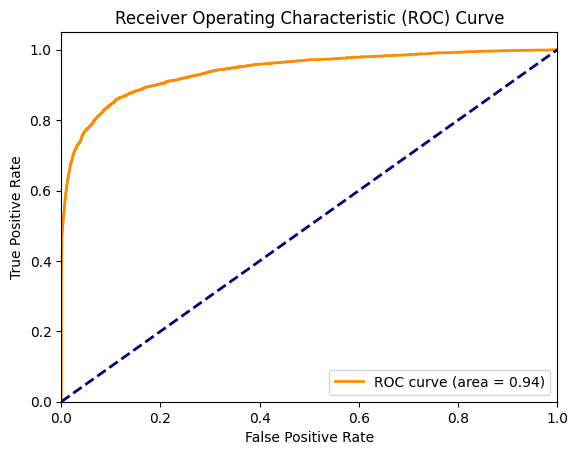

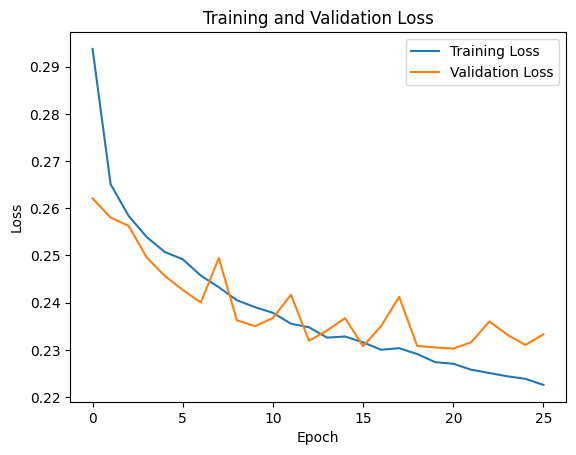

The model is overfitting.


In [71]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, roc_curve, auc
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))  # Input layer
model.add(Dense(units=64, activation='relu'))  # Hidden layer
model.add(Dense(units=1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train_normalized, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the test set
y_pred_proba = model.predict(X_test_normalized)
y_pred = np.round(y_pred_proba)

# Calculate log loss
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss:.4f}')

# Calculate other performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Check for overfitting
if np.any(np.diff(history.history['val_loss']) > 0):
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")


In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create an XGBoost classifier instance
xgb_classifier = xgb.XGBClassifier()

# Train the classifier
xgb_classifier.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_normalized)
y_pred_proba = xgb_classifier.predict_proba(X_test_normalized)[:, 1]  # Predict probabilities for class 1

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

from sklearn.metrics import log_loss

# Calculate log loss
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss:.4f}')



Performance Metrics:
Accuracy: 0.9219
Precision: 0.8896
Recall: 0.7596
F1 Score: 0.8195
Confusion Matrix:
[[14448   427]
 [ 1089  3441]]
Log Loss: 0.2117


In [62]:
def find_best_hyperparameters(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100],       # Reduced number of trees in the forest
        'max_depth': [10, 20],            # Reduced range for maximum depth of the trees
        'min_samples_split': [2, 5],      # Reduced range for minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],       # Reduced range for minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'] # Valid options for number of features to consider
    }

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Perform randomized search cross-validation
    random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Fit the model
    print("Starting Randomized Search for Hyperparameters...")
    random_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)

    return best_params

In [63]:
# Example usage:
# Assuming you have already defined X_train and y_train
best_params = find_best_hyperparameters(X_train, y_train)

<IPython.core.display.Javascript object>

Starting Randomized Search for Hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [64]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier with best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params)

# Train the final model on the entire training dataset
best_rf_classifier.fit(X_train, y_train)

# Now, the best_rf_classifier is ready for making predictions on new data
y_pred = best_rf_classifier.predict(X_test)

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_model_performance(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Evaluate the performance of a classification model and plot a confusion matrix.

    Parameters:
    y_true (numpy.ndarray): The true labels.
    y_pred (numpy.ndarray): The predicted labels.

    Returns:
    None
    """
    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Print performance metrics
    print("Performance Metrics:")
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [accuracy, precision, recall, f1]
    })
    print(metrics_df)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Performance Metrics:
      Metric     Score
0   Accuracy  0.924762
1  Precision  0.901832
2     Recall  0.760486
3   F1 Score  0.825150


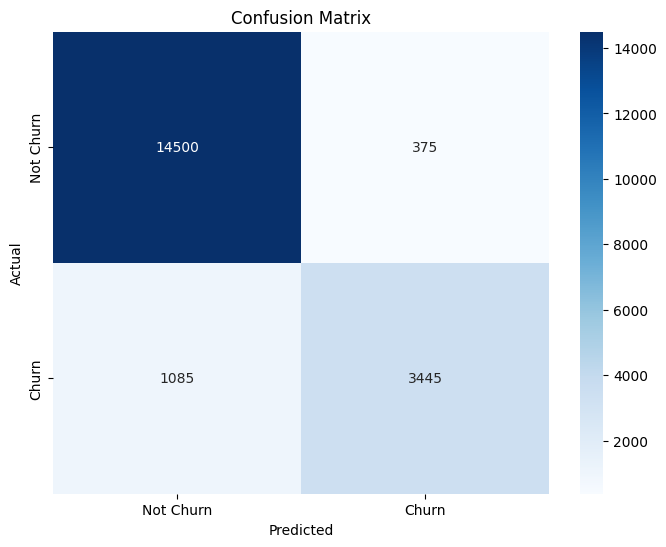

In [66]:
# Example usage:
# Assuming you have already defined y_true and y_pred
evaluate_model_performance(y_test, y_pred)

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_roc_auc(y_true, y_pred_proba):
    """
    Evaluate the ROC curve and AUC (Area Under the Curve) for a classification model.

    Parameters:
    y_true (numpy.ndarray): The true labels.
    y_pred_proba (numpy.ndarray): The predicted probabilities of the positive class.

    Returns:
    None
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

    # Calculate AUC
    auc_score = roc_auc_score(y_true, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

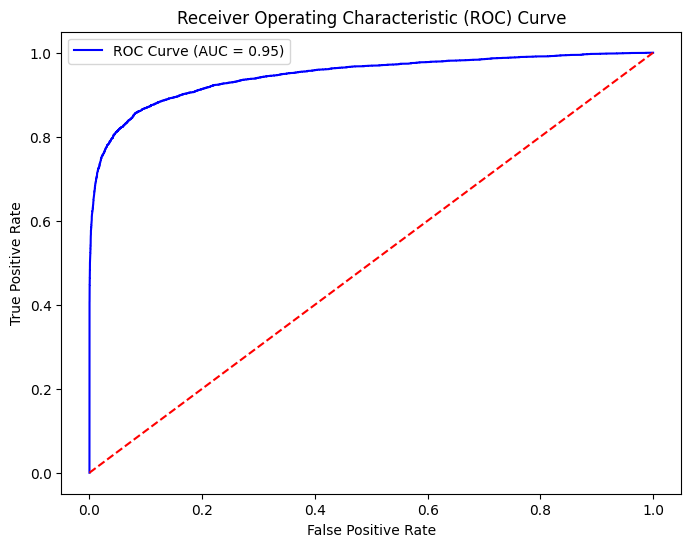

In [68]:
# Assuming you have X_test defined and best_rf_classifier trained
# Make probability predictions on the test set
y_pred_proba = best_rf_classifier.predict_proba(X_test)

# Now, you can call evaluate_roc_auc with y_true and y_pred_proba
evaluate_roc_auc(y_test, y_pred_proba[:, 1])  # Assuming y_test represents binary labels

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3, scoring=None):
    """
    Generate a plot of the learning curve for an estimator.

    Parameters:
    estimator: object
        The machine learning estimator implementing `fit` and `predict` methods.
    X: array-like
        The input samples.
    y: array-like
        The target values.
    train_sizes: array-like, optional (default=np.linspace(0.1, 1.0, 5))
        The relative or absolute number of training examples for which to generate the learning curve.
    cv: int, cross-validation generator or an iterable, optional (default=3)
        Determines the cross-validation splitting strategy.
    scoring: string, callable, list/tuple, or None, optional (default=None)
        A single string (see the `scoring` parameter in `cross_validate`), a callable, or an iterable/tuple.
        If None (default), the estimator's default scorer (if available) is used.

    Returns:
    None
    """
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid(True)

    # Add annotations
    plt.annotate('Overfitting', xy=(train_sizes[-1], train_scores_mean[-1]),
                 xytext=(train_sizes[-1] - 50, train_scores_mean[-1] - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('Underfitting', xy=(train_sizes[-1], train_scores_mean[-1]),
                 xytext=(train_sizes[-1] - 50, train_scores_mean[-1] + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('Good Fit', xy=(train_sizes[-1], train_scores_mean[-1]),
                 xytext=(train_sizes[-1] - 50, train_scores_mean[-1] + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

    # Print summary message
    if train_scores_mean[-1] > validation_scores_mean[-1]:
        print("Model may be overfitting.")
    elif train_scores_mean[-1] < validation_scores_mean[-1]:
        print("Model may be underfitting.")
    else:
        print("Model is fitting well.")


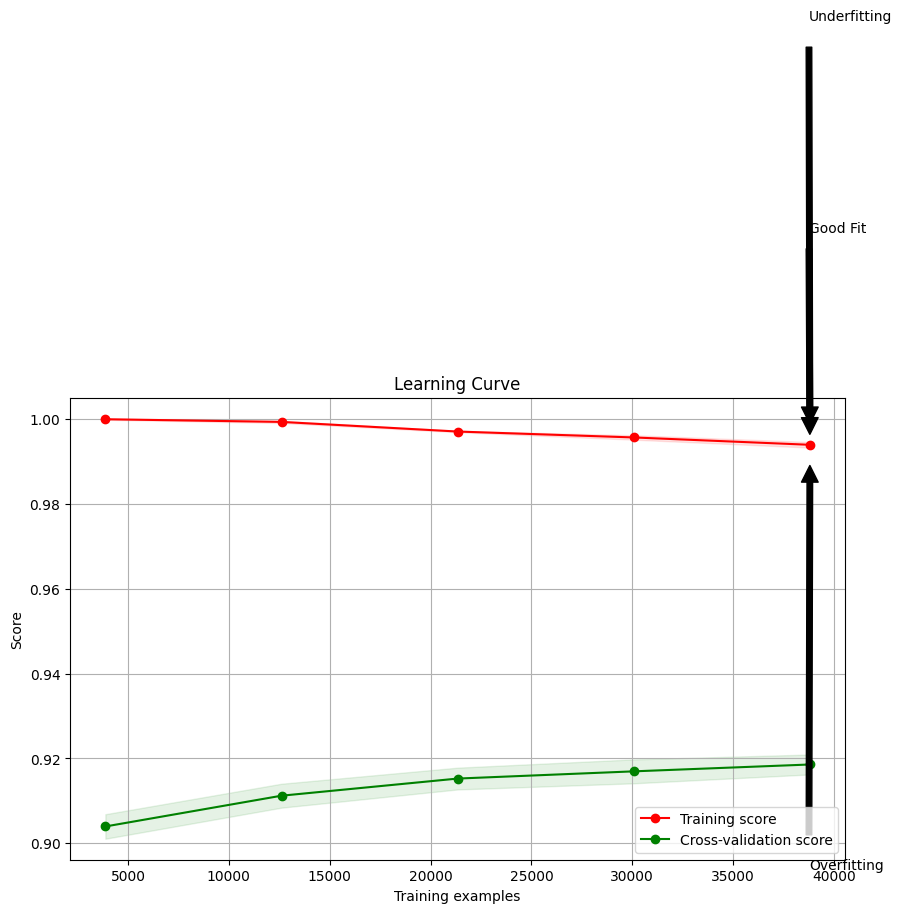

Model may be overfitting.


In [70]:
# Example usage:
# Assuming you have already defined X_train, y_train, and best_rf_classifier trained
plot_learning_curve(best_rf_classifier, X_train, y_train)

https://www.youtube.com/watch?v=SLOyyFHbiqo

https://www.youtube.com/watch?v=3UVXRLBrsK0

https://www.youtube.com/watch?v=1zoxu3N94qU

# Post pruning decision trees with cost complexity pruning

In [ ]:
print(__doc__)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

In [ ]:
pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

In [ ]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Accuracy vs alpha for training and testing sets

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.012)
clf.fit(X_train,y_train)

In [ ]:
pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

In [ ]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)